# Model selection of Alpha in all models using cross validation.

# Organization of code:

The code has been implemented using python class. There are three section in this code  
1) the Generalised Linear model class( a python class) : it has been internally divided into two parts, first is the bunch of functions which are common for all model and then, second, a bunch of functions that are model specific.  
2) supporting functions: there are number of functions which are written as helper functions, mainly includes, data division and plotting functions.  
3) hyperparameter selection part: Every model has been separately written for execution and should run one by one plotting all the required results.  

Note: two files this code has been provided, both are same code but one is ".py" file and another is ".ipynb" file. any one of them can be used for testing code.

# Methodology used : Model selection using cross validation

Here, I am using cross validation method for selecting the value of alpha for all models. For all models, first the data set was divided into 10 folds and one fold is kept aside for testing. Rest of the data is used for training the data and then testing the prediction with the test set. for one value of alpha, each fold is taken as test fold once. Then we calculate the mean error of the fold and plot it with corresponding values of alpha. The range of alpha is taken from 1 to 100 for all models. 

For Ordinal regression, two paramters, alpha and S has been taken and using grid search we are finding the optimal value of both the paramter. The plots are self-explanatory, followed by discussion on plot.


# GLM 


In [66]:
import pandas as pd
import numpy as np
from scipy.stats import logistic as logit
import time
import matplotlib.pyplot as plt
%matplotlib inline

class GLM:
    
    ###### common operation for all models ########      
    def __init__(self, phi, labels, alpha_value, distribution_name, test_label, test_data):
        self.phi_matrix = np.insert(np.array(phi), 0, 1, axis=1) # added 1 at first column of phi for w0.
        self.label = np.array(labels) # the value R in second derivative.
        self.alpha = alpha_value
        self.method = distribution_name.lower()
        self.w_0 = np.zeros((np.shape(self.phi_matrix)[1],1))
        self.label_test = test_label
        self.phi_test = np.insert(np.array(test_data), 0, 1, axis=1)
        
    # finds the first derivative of the model and returns it.
    def first_derivative(self, di: np.ndarray, w: np.ndarray) -> np.ndarray:
        return np.subtract(self.phi_matrix.transpose().dot(di), self.alpha*w)
     
        # finds the second derivative of the model and return the inverse hessian.
    def second_derivative(self, ri: np.ndarray) -> np.ndarray:
        phit_R_phi = self.phi_matrix.transpose().dot(ri).dot(self.phi_matrix)
        hessian = np.add(phit_R_phi, self.alpha*(np.identity(len(phit_R_phi))))
        return np.linalg.inv(hessian)
    
    # implement newton raphson method for finding model paratmer w for each model.
    def newton_raphson(self, s=1) -> np.ndarray:
        start_time = time.time()
        w = self.w_0
        # N_R loop for convergance
        for itr in range(1,101): # for 100 iteration as specified in PP3
            w_old = w
            ri, di = self.yi_di_ri(w, s)
            derivative = self.first_derivative(di,w)
            hessian_inv = self.second_derivative(ri)
            w = w + hessian_inv.dot(derivative)
            if itr >1:
                mat = np.subtract(w, w_old)
                if np.linalg.norm(mat)/ np.linalg.norm(w_old) < 0.001:
                    end_time = round(time.time()- start_time,4)
                    return w, itr, end_time 
                elif itr == 100:
                    end_time = round(time.time()- start_time,4)
                    return w, itr, end_time            
          
        ############ Model based operation ############
     
    # finds the value of yi, ri and di for all models and return ri and di values.
    def yi_di_ri(self, w: np.ndarray, s=1) -> np.ndarray:
        # a_i = phi_tanspose.parameter_W
        ai = self.phi_matrix.dot(w).reshape(len(self.phi_matrix),1)
        ########## Logistic Regression #############
        if self.method == "logistic":
            # yi = sigmoid function
            yi = 1/(1+ np.exp(-1*ai))
            di = np.subtract(self.label, yi) # (t-y)
            # R diag(yi(1- yi))
            ri = np.diagflat(yi*np.subtract(np.ones(np.shape(yi)), yi))
            return ri, di
        ######### Poission Regression ############
        elif self.method == "poisson":
            # exponential function (exp(ai))
            yi = np.exp(ai) 
            di = np.subtract(self.label, yi) #(t-y)
            #R = diag(yi)
            ri = np.diagflat(yi)       
            return ri, di
      ########### Ordinal Regression ############
        elif self.method == "ordinal":      
            # Yij = column vectors yi0, yi1, yi2, yi3, yi4, yi5 which is Nx6.
            # yi0 = 0, yi1 = sigma(-2-ai), yi2 = sigma(-1-ai), yi3 = sigma(0-ai), yi4 = sigma(1-ai), yi5 = 1          
            phi_0 = [-np.inf, -2, -1, 0, 1, np.inf]
            yij = logit.cdf(s*(phi_0 - ai))         
            # di = Y_i,ti + Y_i,(ti-1) -1 
            # ri = diag(s^2(Y_i,ti(1-Y_i,ti) + Y_i,(ti-1)(1 - Y_i,(ti-1)))) where s = 1
            di0 = list()
            ri0 = list()
            for i in range(len(yij)):
                ti = int(np.array(self.label)[i])
                ti0 = int(ti -1) 
                value_di0 = yij[i][ti]+ yij[i][ti0] - 1
                di0.append(value_di0)
                value_ri0 = s**2*[(yij[i][ti]*(1-yij[i][ti])) + (yij[i][ti0]*(1-yij[i][ti0]))]
                ri0.append(value_ri0)
            di = np.array(di0).reshape(-1,1)
            ri1 = np.array(ri0)
            ri = np.diagflat(ri1)
            return ri, di
     
    # Calculates the values of test error and reurns the mean of error.
    def test_error(self, wmap, s=1):
        ###### Logistic Regression ######
        if self.method == "logistic":           
            # predicting the value
            ai_z = self.phi_test.dot(wmap).reshape(len(self.phi_test),1)
            pred = list()
            for x in np.nditer(ai_z):
                if x >= 0:
                    pred.append(1)
                elif x < 0:
                    pred.append(0)
            # counting error (mismatch for logistic regression)
            i = 0  
            error_sum = 0
            for y in np.nditer(self.label_test):
                if y != pred[i]:
                    error_sum +=1
                    i +=1
                else:
                    i +=1
            return error_sum/len(pred)
        
        ######## Poisson Regression ######
        elif self.method == "poisson":
            ai_z = self.phi_test.dot(wmap).reshape(len(self.phi_test),1)
            pred0 = np.exp(ai_z)
            pred = np.floor(pred0)
            # calculating error
            error0 = abs(np.subtract(pred, self.label_test))
            error = [np.floor(x) for x in np.nditer(error0)]
            return sum(error)/len(error)
        
         ###### Ordinal Regression ######
        elif self.method == "ordinal":
            ai_z = self.phi_test.dot(wmap).reshape(len(self.phi_test),1)
            # for potential level j, calculating Y_0 = 0, Y_1 = sigma(-2-ai_z), Y_2 = sigma(-1-ai_z)
            # Y_3 = sigma(0-ai_z), Y_4 = sigma(1-ai_z), Y_5 = 1         
            phi_0 = [-np.inf, -2, -1, 0, 1, np.inf]
            yj = logit.cdf(s*(phi_0 - ai_z))
            
            # P_j = Y_j - Y_j-1 => P1 = y1-y0, P2 = y2-y1, P3 = y3-y2, P4 = y4-y3, P5 = y5-y4
            p1 = np.subtract(yj[:,1],yj[:,0]).reshape(-1,1)
            p2 = np.subtract(yj[:,2],yj[:,1]).reshape(-1,1)
            p3 = np.subtract(yj[:,3],yj[:,2]).reshape(-1,1)
            p4 = np.subtract(yj[:,4],yj[:,3]).reshape(-1,1)
            p5 = np.subtract(yj[:,5],yj[:,4]).reshape(-1,1)
            pj = np.hstack((p1, p2, p3, p4, p5))
            
            # Finding argmax of P_j for each row.
            pred = np.argmax(pj, axis=1) + 1
            error = abs(np.subtract(pred.reshape(-1,1), np.array(self.label_test)))
            return sum(error)/len(error)
        

# supporting functions

In [67]:
# Calculates the model statistics for each model.
def model_statics_calculation(mean_values):
    mean_fold=list()
    std_fold = list()
    for s in range(0,1000, 10):
        p = s +10
        mean_fold.append(np.mean(mean_values[s:p]))
        std_fold.append(np.std(mean_values[s:p]))
    return mean_fold, std_fold

# plots the mean error with values of alpha.
def alpha_plot(error, sd, name):
    sd = 0
    x1 = range(1,101)
    plt.figure()
    plt.errorbar(x1, error, sd, label = "mean error")
    plt.xlabel('Values of Alpha')
    plt.ylabel("Mean Error")
    plt.legend(loc="upper left")
    plt.title("Mean error vs Alpha plot for {} data set".format(name))      
    plt.rcParams["figure.figsize"]=(15,7)
    return plt.show()

# plots the mean error for ordinal with values of alpha for ordinal regression
def alpha_plot_ordinal(error, sd, name): 
    sd = 0
    x1 = range(1,101)
    plt.figure()
    plt.errorbar(x1, error[0], sd, label = "for s = 1")
    plt.errorbar(x1, error[1], sd, label = "for s = 3")
    plt.errorbar(x1, error[2], sd, label = "for s = 5")
    plt.errorbar(x1, error[4], sd, label = "for s = 7")
    plt.errorbar(x1, error[5], sd, label = "for s = 9")
    plt.xlabel('Sample Size')
    plt.ylabel("Mean convergence time")
    plt.legend(loc="upper left")
    plt.title("convergence time curve for across model")    
    plt.rcParams["figure.figsize"]=(15,7)
    return plt.show()


# Logistic regression hyperparameter selection using cross validation

# Data set A 

In [14]:
data_matrix_l = pd.read_csv("A.csv", header = None)
labels_l = pd.read_csv("labels-A.csv", header = None)

run_time_lgr = list()
iterations_lgr = list()
test_errors_lgr = list() 
 
########### dividing the data set for cross validation and finding the error ###############
step_size = int(len(data_matrix_l)/10)
for value in range(1,101): # values on alpha
    for i in range(0, 10*step_size, step_size):
            b=i + step_size
            test_data_l = data_matrix_l[i:b]
            test_label_l = labels_l[i:b]
            train_data_l = np.concatenate((data_matrix_l[0:i],data_matrix_l[b:]), axis=0)
            train_label_l = np.concatenate((labels_l[0:i],labels_l[b:]), axis=0)

            logistic = GLM(train_data_l, train_label_l, value, "logistic", test_label_l, test_data_l )
            # getting W_map, number of iteration and convergence time 
            w_map_l, iterr_l, running_time_l = logistic.newton_raphson()
            run_time_lgr.append(running_time_l)
            iterations_lgr.append(iterr_l)
            # Do prediction using W_map and note the total error for each iteration.
            errorsum_t = logistic.test_error(w_map_l)
            test_errors_lgr.append(errorsum_t)


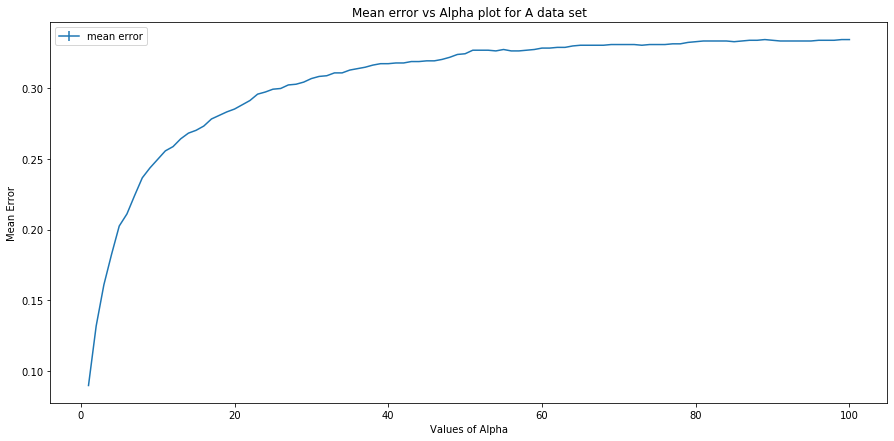

In [15]:
# model statistics calculations
test_err_kfold_A, test_std_kfold_A = model_statics_calculation(test_errors_lgr)
# plotting mean error with values of alpha.
alpha_plot(test_err_kfold_A, test_std_kfold_A, "A")

Discussion: the value of mean error increase rapidly as the value of alpha is increased for Logistic regression on data set A. Logistic regression is giving smallest error at small values of alpha. The rate of increase of mean error reduces as the alpha value increase and after alpha >60 it reamins almost constant. For alpha = 1, mean erro is 0.09 and it reaches the value of 0.33 for alpha = 100. Therefore, we can conclude that logistic regression is more effective with smaller values of alpha.

# data set USPS

In [12]:
data_matrix_l2 = pd.read_csv("usps.csv", header = None)
labels_l2 = pd.read_csv("labels-usps.csv", header = None)
step_size_l2 = int(len(data_matrix_l2)/10)
run_time_l2 = list()
iterations_l2 = list()
errors_l2 = list() 

########### dividing the data set for cross validation and finding the error ###############
for value in range(1,101): # values on alpha
    for i in range(0, 10*step_size_l2, step_size_l2):
            b=i + step_size_l2
            test_data_l2 = data_matrix_l2[i:b]
            test_label_l2 = labels_l2[i:b]
            train_data_l2 = np.concatenate((data_matrix_l2[0:i],data_matrix_l2[b:]), axis=0)
            train_label_l2 = np.concatenate((labels_l2[0:i],labels_l2[b:]), axis=0)

            logistic2 = GLM(train_data_l2, train_label_l2, value, "logistic", test_label_l2, test_data_l2 )
            # getting W_map, number of iteration and convergence time 
            w_map_l2, iterr_l2, running_time_l2 = logistic2.newton_raphson()
            run_time_l2.append(running_time_l2)
            iterations_l2.append(iterr_l2)
            # Do prediction using W_map and note the total error for each iteration.
            errorsum2 = logistic2.test_error(w_map_l2)
            errors_l2.append(errorsum2)


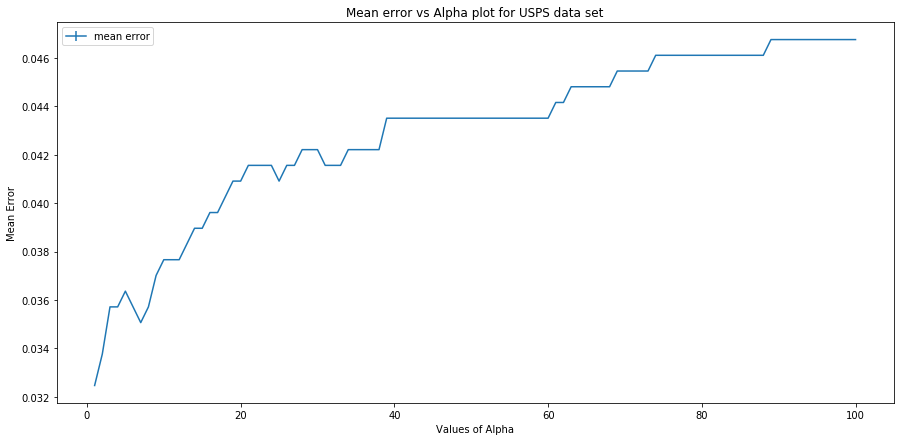

In [69]:
# model statistics calculations
mean_err_kfold_usps, std_kfold_usps = model_statics_calculation(errors_l2)
# plotting mean error with values of alpha.
alpha_plot(mean_err_kfold_usps, std_kfold_usps, "USPS")

Discussion: the value of mean error increase rapidly as the value of alpha is increased for Logistic regression on data set USPS. Logistic regression is giving smallest error at small values of alpha. The rate of increase of mean error reduces as the alpha value increase and after alpha >40 it reamins almost constant. For alpha = 1, mean erro is 0.032 and it reaches the value of 0.046 for alpha = 100. Therefore, we can conclude that logistic regression is more effective with smaller values of alpha.

# Poisson regression hyperparameter selection

In [7]:
# getting data
data_matrix_p = pd.read_csv("AP.csv", header = None)
labels_p = pd.read_csv("labels-AP.csv", header = None)

run_time_poi = list()
iterations_poi = list()
abs_errors_poi = list()

########### dividing the data set for cross validation and finding the error ###############
step_size_p = int(len(data_matrix_p)/10)
for value in range(1,101): # values on alpha
    for i in range(0, 10*step_size_p, step_size_p):
            b=i + step_size_p
            test_data_p = data_matrix_p[i:b]
            test_label_p = labels_p[i:b]
            train_data_p = np.concatenate((data_matrix_p[0:i],data_matrix_p[b:]), axis=0)
            train_label_p = np.concatenate((labels_p[0:i],labels_p[b:]), axis=0)

            poisson = GLM(train_data_p, train_label_p, value, "poisson", test_label_p, test_data_p )
            # getting W_map, number of iteration and convergence time 
            w_map_p, iterr_p, running_time_p = poisson.newton_raphson()
            run_time_poi.append(running_time_p)
            iterations_poi.append(iterr_p)
            # Do prediction using W_map and note the total error for each iteration.
            error_ = poisson.test_error(w_map_p)
            abs_errors_poi.append(error_)


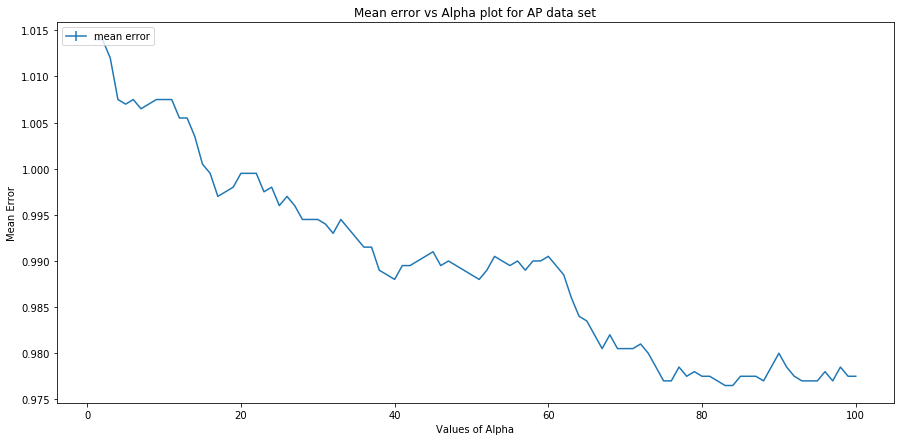

In [70]:
# model statistics calculations
mean_err_kfold_AP, std_kfold_AP = model_statics_calculation(abs_errors_poi)
# plotting mean error with values of alpha.
alpha_plot(mean_err_kfold_AP, std_kfold_AP, "AP")

Discussion: the value of mean error decreases gradually as the value of alpha is increased for Poisson regression on data set AP. Poisson regression is giving smallest error at large values of alpha. For alpha = 1, mean erro is 1.014 and it reaches the value of 0.97 for alpha = 100. for alpha >80 the mean error stabilises to smaller values. Therefore, we can conclude that poisson regression is more effective with larger values of alpha. Here we can choose values close to 80 for practical application with this data set.

# Ordinal Regression prediction and plot

In [56]:
# getting data
data_matrix_o = pd.read_csv("AO.csv", header = None)
labels_o = pd.read_csv("labels-AO.csv", header = None)

run_time_ord = list()
iterations_ord = list()
abs_errors_ord0 = list()

########### dividing the data set for cross validation and finding the error ###############
step_size_o = int(len(data_matrix_o)/10)
for s in range(1,12, 2):
    for value in range(1,101): # values on alpha
        for i in range(0, 10*step_size_o, step_size_o):
                b=i + step_size_o
                test_data_o = data_matrix_o[i:b]
                test_label_o = labels_o[i:b]
                train_data_o = np.concatenate((data_matrix_o[0:i],data_matrix_o[b:]), axis=0)
                train_label_o = np.concatenate((labels_o[0:i],labels_o[b:]), axis=0)

                ordinal = GLM(train_data_o, train_label_o, value, "ordinal", test_label_o, test_data_o )
                # getting W_map, number of iteration and convergence time 
                w_map_o, iterr_o, running_time_o = ordinal.newton_raphson()
                run_time_ord.append(running_time_o)
                iterations_ord.append(iterr_o)
                # Do prediction using W_map and note the total error for each iteration.
                error_ = ordinal.test_error(w_map_o)
                abs_errors_ord0.append(error_)
                abs_errors_ord = [x[0] for x in abs_errors_ord0]



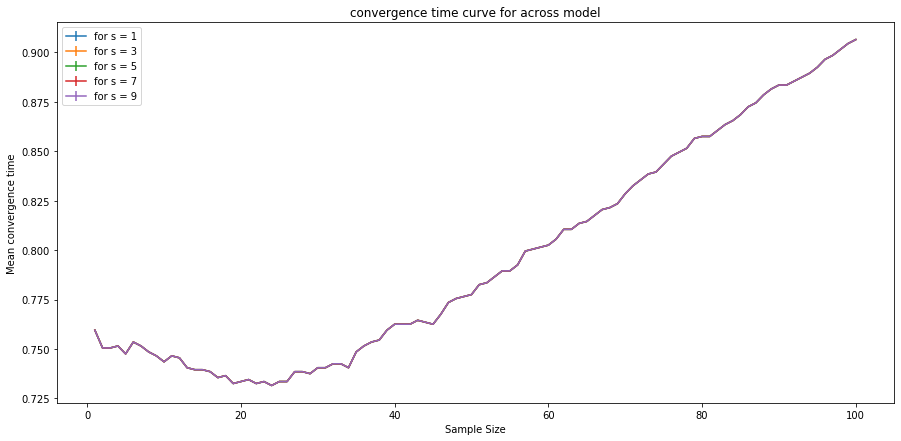

In [71]:
# calculating data statistics.
mean_err_kfold_AO = list()
std_kfold_AO = list()
for x in range(0, 5001, 1000):
    y = x + 1000
    a0 = abs_errors_ord[x:y]
    mean_AO, std_AO = model_statics_calculation(a0)
    mean_err_kfold_AO.append(mean_AO)
    std_kfold_AO.append(std_AO)
    
# plotting mean error with values of alpha.
alpha_plot_ordinal(mean_err_kfold_AO, std_kfold_AO, "AO")

Discussion: For this, after doing a lot of trail run, i settled with the some random values of S, as it was not making much impact on the mean error. This is direclty evident on the plot where for all vlaues of s, mean error vs alpha plot traces same path exactly.

The value of mean error start at o.75 for alpha = 1 but then it slowly decreases and attains the minimum value of mean error around alpha 20 to 25. After attaining the minimum value, it starts to increase for rest of the values of alpha. Here, for effective performance of model, we can choose values of alpha between 20 to 25. 